In [1]:
import pickle

In [2]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras as kr
from keras.models import Sequential
from tensorflow.keras import layers, activations, initializers, Input
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.python.framework import tensor_shape
import matplotlib.pyplot as plt
import keras
from tensorflow import data as tf_data
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
datasetTreino = keras.utils.image_dataset_from_directory(
    "C:\Projeto MS904\Sign Language for Alphabets TRAIN",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="grayscale",
    batch_size=None,
    image_size=(100, 100),
    shuffle=True,
    seed=4147,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True
)

Found 34460 files belonging to 27 classes.


In [5]:
datasetTeste = keras.utils.image_dataset_from_directory(
    "C:\Projeto MS904\Sign Language for Alphabets TEST",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="grayscale",
    batch_size=None,
    image_size=(100, 100),
    shuffle=True,
    seed=4147,
    validation_split=None,   
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True
)

Found 6098 files belonging to 27 classes.


Processa dados para np.array

In [6]:
listaDatasetTreino = list(datasetTreino)
listaDatasetTeste = list(datasetTeste)

In [7]:
data_augmentation_layers = [
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.15)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

In [8]:
class V_Conv2D(kr.layers.Layer):
    def __init__(self,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='VALID',
                 use_bias=True,
                 activation=None,
                 initializer='glorot_normal',
                 data_format=None,
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1) # Complex Numbers
                ):
        super(V_Conv2D, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
        self.activation = kr.activations.get(activation)
        self.initializer = kr.initializers.get(initializer)
        self.data_format = data_format
        self.algebra = np.float32(algebra)
        self.alg_dim = algebra.shape[2]

    def _get_channel_axis(self):
        if self.data_format == 'channels_first':
            raise ValueError('V_Conv2d is designed only for channels_last. '
                             'The input must be changed to channels last!')
        else:
            return -1

    def _get_input_channel(self, input_shape):
        channel_axis = self._get_channel_axis()
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        return int(input_shape[channel_axis])

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        if input_channel % self.alg_dim != 0:
            raise ValueError('The number of input channels must be divisible by %d.' % self.alg_dim)

        self.input_dim = input_channel // self.alg_dim
        kernel_shape = self.kernel_size + (self.input_dim, self.filters, self.alg_dim)

        self.kernel = self.add_weight(
            name='kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.alg_dim*self.filters,),
                initializer="zeros",
                trainable=True,
                dtype=self.dtype)
        else:
            self.bias = None

    def call(self, inputs):
        # Filter multiplied from the right!
        W = sum([tf.experimental.numpy.kron(self.algebra[k,:,:].reshape(1,1,self.alg_dim,self.alg_dim),self.kernel[:,:,:,:,k]) for k in range(self.alg_dim)])
        outputs = tf.nn.conv2d(inputs, W, strides=self.strides, padding=self.padding)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs,self.bias)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

Ajustando modelo

In [9]:
# Será utilizado a algebra complexa
complex_numbers = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)

## Transforma de Fourier

In [11]:
from keras.src.backend.numpy.core import convert_to_tensor
from numpy import inf

class zReLU(kr.layers.Layer):

    def __init__(
        self, max_value=None, negative_slope=0.0, threshold=0.0, **kwargs
    ):
        super().__init__(**kwargs)
        if max_value is not None and max_value < 0.0:
            raise ValueError(
                "max_value of a ReLU layer cannot be a negative "
                f"value. Received: max_value={max_value}"
            )
        if negative_slope is None or negative_slope < 0.0:
            raise ValueError(
                "negative_slope of a ReLU layer cannot be a negative "
                f"value. Received: negative_slope={negative_slope}"
            )
        if threshold is None or threshold < 0.0:
            raise ValueError(
                "threshold of a ReLU layer cannot be a negative "
                f"value. Received: threshold={threshold}"
            )

        self.supports_masking = True
        self.max_value = max_value
        self.negative_slope = negative_slope
        self.threshold = threshold

    def call(self, inputs):
      #x = inputs.numpy(dtype=inputs.dtype)

      x = inputs

      A = tf.multiply(x,1.)

      canais = x.shape[-1]

      if canais%2 != 0:
        raise ValueError(
                    "Número de canais deve ser par"
                    f"valor. Recebido: canais={canais}"
                )

      x = tf.math.divide_no_nan(x[:,:,:,int(canais/2):canais], x[:,:,:,0:int(canais/2)])

      x = x * tf.cast((x)%(2*np.pi) < np.pi/2, x.dtype)
      x = x * tf.cast((x)%(2*np.pi) > 0, x.dtype)

      x = tf.concat([x, x], axis=3)

      x = tf.math.divide_no_nan(x, x)

      x = tf.multiply(x,A)

      return x

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_value": self.max_value,
                "negative_slope": self.negative_slope,
                "threshold": self.threshold,
            }
        )
        return config

    def compute_output_shape(self, input_shape):
        return input_shape

# Aplicada augumentação nas imagens

In [12]:
aug_datasetTreino = datasetTreino.map(
  lambda x, y: (data_augmentation(x), y))

listaDatasetTreino_aug = list(aug_datasetTreino)

listaDatasetTreino_aug

[(<tf.Tensor: shape=(100, 100, 1), dtype=float32, numpy=
  array([[[173.95888],
          [172.96518],
          [171.01718],
          ...,
          [166.94254],
          [167.2915 ],
          [168.70518]],
  
         [[174.45697],
          [173.75151],
          [172.45607],
          ...,
          [167.30966],
          [167.81519],
          [169.17366]],
  
         [[174.06244],
          [174.25703],
          [173.78624],
          ...,
          [167.53671],
          [168.36136],
          [169.48471]],
  
         ...,
  
         [[145.3425 ],
          [144.99507],
          [144.99507],
          ...,
          [146.68661],
          [147.19215],
          [147.69768]],
  
         [[145.84802],
          [144.77036],
          [144.26482],
          ...,
          [147.66061],
          [148.16615],
          [149.05614]],
  
         [[145.39926],
          [144.18082],
          [143.29082],
          ...,
          [148.98203],
          [149.9931 ],
          [

In [13]:
listaDatasetTreino_aug = listaDatasetTreino + listaDatasetTreino_aug

# Aplicando a trasnformada

# AAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [14]:
y_treino = np.array([listaDatasetTreino_aug[0][1].numpy()])
for i in range(1,len(listaDatasetTreino_aug)):
  y_treino = np.append(y_treino, np.array([listaDatasetTreino_aug[i][1].numpy()]), axis=0)

In [15]:
y_teste = np.array([listaDatasetTeste[0][1].numpy()])
for i in range(1,len(listaDatasetTeste)):
  y_teste = np.append(y_teste, np.array([listaDatasetTeste[i][1].numpy()]), axis=0)

In [16]:
ffx_treino = np.array([    np.log(abs(np.fft.fftshift(np.fft.fft2(listaDatasetTreino_aug[0][0]))))    ])
for i in range(1,len(listaDatasetTreino_aug)): #len(listaDatasetTreino_aug)
  aux = np.fft.fft2(listaDatasetTreino_aug[i][0])
  aux = np.fft.fftshift(aux)
  aux = abs(aux)
  np.log(aux, out=aux, where=aux > 0)
  ffx_treino = np.append(ffx_treino, np.array([   aux   ]), axis=0)


In [17]:
ffx_teste = np.array([    np.log(abs(np.fft.fftshift(np.fft.fft2(listaDatasetTeste[0][0]))))    ])
for i in range(1,len(listaDatasetTeste)): #len(listaDatasetTeste)
  aux = np.fft.fft2(listaDatasetTeste[i][0])
  aux = np.fft.fftshift(aux)
  aux = abs(aux)
  np.log(aux, out=aux, where=aux > 0)
  ffx_teste = np.append(ffx_teste, np.array([   aux   ]), axis=0)


# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

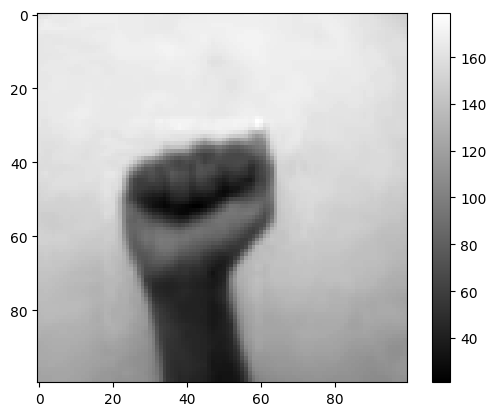

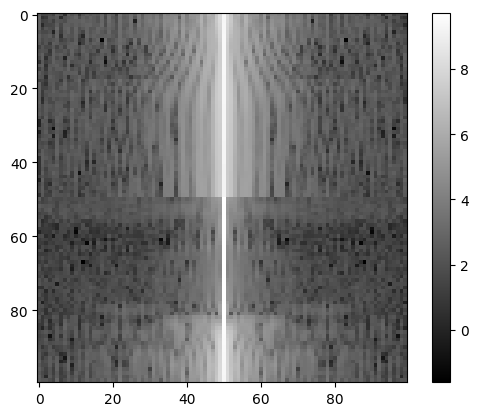

In [31]:
im = plt.imshow( listaDatasetTreino_aug[3][0] , cmap='gray')
plt.colorbar(im)
plt.show()

im = plt.imshow( ffx_treino[3,:,:] , cmap='gray')
plt.colorbar(im)
plt.show()

# Preparando a imagem complexa

In [18]:
ffx_treino2 = np.concatenate((np.zeros((ffx_treino.shape[0],ffx_treino.shape[1],ffx_treino.shape[1],1)),ffx_treino),axis=-1)
ffx_teste2 = np.concatenate((np.zeros((ffx_teste.shape[0],ffx_teste.shape[1],ffx_teste.shape[1],1)),ffx_teste),axis=-1)
ffx_treino2.shape, ffx_teste2.shape

((68920, 100, 100, 2), (6098, 100, 100, 2))

In [19]:
keras.backend.clear_session()

In [20]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = keras.layers.Normalization(axis=1)(inputs)

    x = V_Conv2D(32, (3,3), strides=2, padding="SAME",algebra=complex_numbers)(x)
    x = layers.BatchNormalization()(x)
    x = zReLU()(x)

    previous_block_activation = x  # Set aside residual

    x = V_Conv2D(48, (3,3), padding="SAME",algebra=complex_numbers)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = zReLU()(x)
    
    x = V_Conv2D(48, (3,3), padding="SAME",algebra=complex_numbers)(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = V_Conv2D(48, (1,1), strides=2, padding="SAME",algebra=complex_numbers)(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual

    x = V_Conv2D(148, (3,3), padding="SAME",algebra=complex_numbers)(x)
    x = layers.BatchNormalization()(x)
    x = zReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    # We specify activation=None so as to return logits

    outputs = Dense(27, activation='softmax')(x)
    return keras.Model(inputs, outputs)

myModelHipComplexoFF = make_model(input_shape=(100, 100, 2), num_classes=27)
keras.utils.plot_model(myModelHipComplexoFF, show_shapes=True)
myModelHipComplexoFF.summary()

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 100, 100,  │        201 │ input_layer[0][0] │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v__conv2d           │ (None, 50, 50,    │        640 │ normalization[0]… │
│ (V_Conv2D)          │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 50,    │        256 │ v__conv2d[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_re_lu (zReLU)     │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v__conv2d_1         │ (None, 50, 50,    │     27,744 │ z_re_lu[0][0]     │
│ (V_Conv2D)          │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        384 │ v__conv2d_1[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_re_lu_1 (zReLU)   │ (None, 50, 50,    │          0 │ dropout[0][0]     │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v__conv2d_2         │ (None, 50, 50,    │     41,568 │ z_re_lu_1[0][0]   │
│ (V_Conv2D)          │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        384 │ v__conv2d_2[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 25, 25,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v__conv2d_3         │ (None, 25, 25,    │      3,168 │ z_re_lu[0][0]     │
│ (V_Conv2D)          │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 25, 25,    │          0 │ max_pooling2d[0]… │
│                     │ 96)               │            │ v__conv2d_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v__conv2d_4         │ (None, 25, 25,    │    128,168 │ add[0][0]         │
│ (V_Conv2D)          │ 296)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │      1,184 │ v__conv2d_4[0][0] │
│ (BatchNormalizatio… │ 296)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_re_lu_2 (zReLU)   │ (None, 25, 25,    │          0 │ batch_normalizat

 Total params: 211,716 (827.02 KB)

 Trainable params: 210,411 (821.92 KB)

 Non-trainable params: 1,305 (5.10 KB)

In [93]:
ffx_treino2[~np.isfinite(ffx_treino2)] = 0
ffx_teste2[~np.isfinite(ffx_teste2)] = 0

In [181]:
ffx_treino2.shape, y_treino.shape

((68920, 100, 100, 2), (68920, 27))

In [25]:
myModelHipComplexoFF = make_model(input_shape=(100, 100, 2), num_classes=27)
myModelHipComplexoFF.load_weights("C:/Projeto MS904/FFCompTreinoModelo.weights.h5") 

In [24]:
with open("ffx_treino2", 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(ffx_treino2, file)

In [26]:
epochs = 80


callbacks = [
    keras.callbacks.ModelCheckpoint("FFCompTreinoModelo2.weights.h5",save_weights_only=True),
]
myModelHipComplexoFF.compile(
    #run_eagerly=True,
    optimizer='adam',
    loss=kr.losses.categorical_crossentropy,
    metrics=['accuracy']
)
historico = myModelHipComplexoFF.fit(
    ffx_treino2,
    y_treino,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=32,
    validation_split = 0.15 
)

Epoch 1/80
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1474s 802ms/step - accuracy: 0.7388 - loss: 0.9277 - val_accuracy: 0.4081 - val_loss: 3.3470
Epoch 2/80
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1448s 791ms/step - accuracy: 0.7441 - loss: 0.9098 - val_accuracy: 0.4856 - val_loss: 2.0591
Epoch 3/80
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1447s 790ms/step - accuracy: 0.7410 - loss: 0.9122 - val_accuracy: 0.5609 - val_loss: 1.8555
Epoch 4/80
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1449s 791ms/step - accuracy: 0.7437 - loss: 0.9031 - val_accuracy: 0.5498 - val_loss: 1.7015
Epoch 5/80
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1451s 793ms/step - accuracy: 0.7445 - loss: 0.8912 - val_accuracy: 0.5802 - val_loss: 1.6214
Epoch 6/80
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1451s 793ms/step - accuracy: 0.7480 - loss: 0.8881 - val_accuracy: 0.5578 - val_loss: 1.6833
Epoch 7/80
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1451s 792ms/step - accuracy: 0.7513 - loss: 0.8668 - val_accuracy: 0.5035 - val_loss: 2.3639
Epoch 8/80
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1451s 792ms/s

In [27]:
# Salva o histórico

with open('C:/Projeto MS904/FFCompTreinoHistoryDict', 'wb') as file_pi:
    pickle.dump(historico.history, file_pi)

In [28]:
# Testa o modelo:

historicoTeste = myModelHipComplexoFF.evaluate(ffx_teste2,y_teste, return_dict=True)

with open('C:/Projeto MS904/RealTesteHistoryDict', 'wb') as file_pi:
    pickle.dump(historicoTeste, file_pi)

#200ms/step - accuracy: 0.8207 - loss: 0.7405

191/191 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.8207 - loss: 0.7405


In [ ]:
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1667s 907ms/step - accuracy: 0.3073 - loss: 2.3909 - val_accuracy: 0.1358 - val_loss: 4.6535
Epoch 2/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1659s 906ms/step - accuracy: 0.5720 - loss: 1.5467 - val_accuracy: 0.2052 - val_loss: 4.5844
Epoch 3/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1655s 904ms/step - accuracy: 0.6275 - loss: 1.3601 - val_accuracy: 0.2917 - val_loss: 3.6803
Epoch 4/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1652s 902ms/step - accuracy: 0.6557 - loss: 1.2611 - val_accuracy: 0.3020 - val_loss: 3.7947
Epoch 5/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1652s 902ms/step - accuracy: 0.6717 - loss: 1.1901 - val_accuracy: 0.4075 - val_loss: 2.7583
Epoch 6/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1651s 902ms/step - accuracy: 0.6837 - loss: 1.1330 - val_accuracy: 0.3066 - val_loss: 3.6342
Epoch 7/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1649s 901ms/step - accuracy: 0.6946 - loss: 1.0966 - val_accuracy: 0.3269 - val_loss: 3.8808
Epoch 8/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1651s 902ms/step - accuracy: 0.7008 - loss: 1.0671 - val_accuracy: 0.2914 - val_loss: 3.8772
Epoch 9/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1649s 901ms/step - accuracy: 0.7061 - loss: 1.0474 - val_accuracy: 0.3562 - val_loss: 3.0687
Epoch 10/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1652s 902ms/step - accuracy: 0.7057 - loss: 1.0426 - val_accuracy: 0.5368 - val_loss: 1.9029
Epoch 11/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1649s 900ms/step - accuracy: 0.7152 - loss: 1.0135 - val_accuracy: 0.4485 - val_loss: 2.5532
Epoch 12/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1635s 893ms/step - accuracy: 0.7181 - loss: 0.9906 - val_accuracy: 0.2816 - val_loss: 4.3217
Epoch 13/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1635s 893ms/step - accuracy: 0.7205 - loss: 0.9907 - val_accuracy: 0.5230 - val_loss: 1.8591
Epoch 14/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1640s 896ms/step - accuracy: 0.7252 - loss: 0.9746 - val_accuracy: 0.4640 - val_loss: 2.4072
Epoch 15/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1637s 894ms/step - accuracy: 0.7289 - loss: 0.9614 - val_accuracy: 0.4797 - val_loss: 2.4916
Epoch 16/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1632s 891ms/step - accuracy: 0.7301 - loss: 0.9540 - val_accuracy: 0.4992 - val_loss: 2.1706
Epoch 17/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1628s 889ms/step - accuracy: 0.7332 - loss: 0.9517 - val_accuracy: 0.4538 - val_loss: 2.1812
Epoch 18/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1627s 889ms/step - accuracy: 0.7359 - loss: 0.9369 - val_accuracy: 0.4422 - val_loss: 2.5867
Epoch 19/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1630s 890ms/step - accuracy: 0.7398 - loss: 0.9147 - val_accuracy: 0.4366 - val_loss: 2.5074
Epoch 20/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1629s 890ms/step - accuracy: 0.7378 - loss: 0.9241 - val_accuracy: 0.5030 - val_loss: 2.1049
Epoch 21/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1627s 889ms/step - accuracy: 0.7351 - loss: 0.9260 - val_accuracy: 0.4986 - val_loss: 2.3475
Epoch 22/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1631s 891ms/step - accuracy: 0.7415 - loss: 0.9115 - val_accuracy: 0.4254 - val_loss: 3.0425
Epoch 23/100
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 1643s 897ms/step - accuracy: 0.7418 - loss: 0.9071 - val_accuracy: 0.5004 - val_loss: 2.3106
Epoch 24/100
1741/1831 ━━━━━━━━━━━━━━━━━━━━ 1:20 893ms/step - accuracy: 0.7440 - loss: 0.8931

In [33]:
# minha maquina crashou no processamento das 20 primeiras épocas

acc = [0.3073,0.5720,0.6275,0.6557,0.6717,0.6837,0.6946,0.7008,0.7061,0.7057,0.7152,0.7181,0.7205,0.7252,0.7289,0.7301,0.7332,0.7359,0.7398,0.7378,0.7351,0.7415,0.7418]

acc_loss = [2.3909,1.5467,1.3601,1.2611,1.1901,1.1330,1.0966,1.0671,1.0474,1.0426,1.0135,0.9906,0.9907,0.9746,0.9614,0.9540,0.9517,0.9369,0.9147,.9241,0.9260,0.9115,0.9071]

val_accurary = [0.1358,0.2052,0.2917,0.3020,0.4075,0.3066,0.3269,0.2914,0.3562,0.5368,0.4485,0.2816,0.5230,0.4640,0.4797,0.4992,0.4538,0.4422,0.4366,0.5030,0.4986,0.4254,0.5004]

val_loss = [4.6535,4.5844,3.6803,3.7947,2.7583,3.6342,3.8808,3.8772,3.0687,1.9029,2.5532,4.3217,1.8591,2.4072,2.4916,2.1706,2.1812,2.5867,2.5074,2.1049,2.3475,3.0425,2.3106]

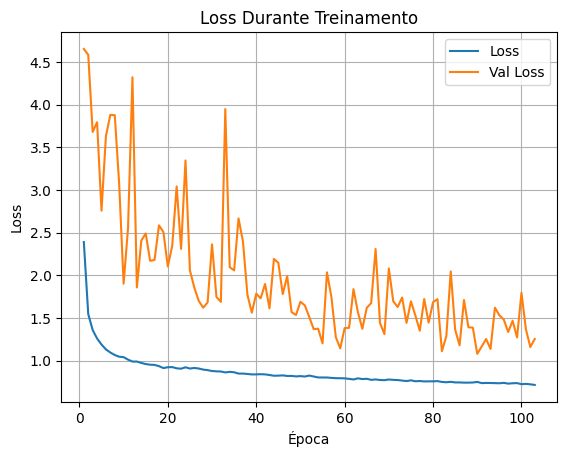

In [35]:
# Plota os dados de treinamento

treino_loss_ffcomp = acc_loss + historico.history['loss']
treino_val_loss_ffcomp = val_loss + historico.history['val_loss']

epocas_ffcomp = range(1, 104) 

plt.plot(epocas_ffcomp, treino_loss_ffcomp)
plt.plot(epocas_ffcomp, treino_val_loss_ffcomp)
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss Durante Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

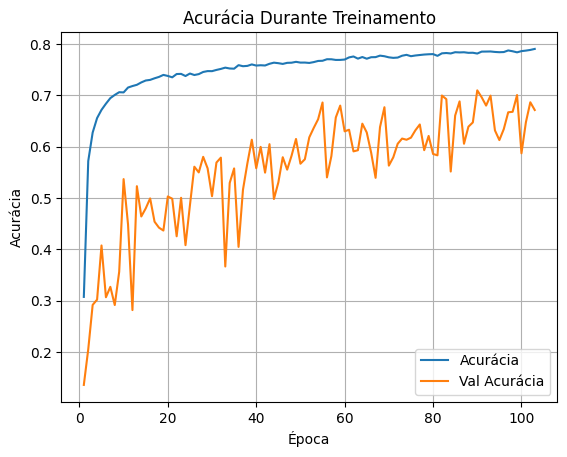

In [36]:
treino_prec_ffcomp = acc + historico.history['accuracy']
treino_val_prec_ffcomp = val_accurary + historico.history['val_accuracy']

epocas_ffcomp = range(1, 104) 

plt.plot(epocas_ffcomp, treino_prec_ffcomp)
plt.plot(epocas_ffcomp, treino_val_prec_ffcomp)
plt.legend(['Acurácia', 'Val Acurácia'])
plt.title('Acurácia Durante Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()